In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings(model="text-embedding-3-large")

In [3]:
from langchain_chroma import Chroma

# vector_store = Chroma.from_documents(
#     documents=document_list,
#     embedding=embedding,
#     collection_name="chroma_tax",
#     persist_directory="./chroma_tax"
# )

vector_store = Chroma(
    collection_name="chroma_tax",
    embedding_function=embedding,
    persist_directory="./chroma_tax"
)

In [4]:
retriever = vector_store.as_retriever(search_kwargs={"k" : 3})
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x0000022FDD4DA7D0>, search_kwargs={'k': 3})

In [5]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]     #retriever에 있는 문서에서 읽어오겠다
    answer : str
    
graph_builder = StateGraph(AgentState)

In [6]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다. 
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state
        
    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}        #크로마디비에서 검색된 문서 


    

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [8]:
from langchain import hub

generate_prompt = hub.pull('rlm/rag-prompt')

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    
    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | llm
    
    response = rag_chain.invoke({
        'question': query,
        'context' : context,
    })
    
    return {'answer': response}

c:\AI_Prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [9]:
from langchain import hub
from typing import Literal

#문서 관련성 체크 
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

#분기문. 특정 노드 언급이 제일 좋음. 
def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다. 
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.
        
    Returns: 
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite'를 반환합니다.
        
    
    """
    
    query = state['query']
    context = state['context']
    
    doc_relevance_chain = doc_relevance_prompt | llm 
    
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    
    if response['Score'] == 1:
        print('관련성 : relevant')
        return 'relevant'
    print('관련성 : irrelevant')
    return 'irrelevant'
    

c:\AI_Prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [10]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ["사람과 관련된 표현 -> 거주자"]

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전: {dictionary}
질문: {{query}}     
""")
#f-string사용해서 {}한번 더 해줘야함. 
def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 고려하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다. 
    """
    
    query = state['query']
    #chain
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()        
                                            #전체를 str로 반환. 이게 다시 질문이 되야하기 때문
    
    response = rewrite_chain.invoke({'query': query})
    
    return {'query': response}

In [11]:
from langchain_core.output_parsers import StrOutputParser

hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from income tax law, and a student's answer;
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated".

documents: {documents}      
student_answer: {student_answer}      
""")
# documents: {documents}      #검색기로 가져온 문서 
# student_answer: {student_answer}        #generate가 만든 답변

#hallucination 검사할 때는 답이 딱 정해져야하기 때문에 llm 따로 해야함. 
hallucination_llm = ChatOpenAI(model='gpt-4o', temperature=0)

def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']        #generate 노드에서 만들어준 결과값
    context = state['context']
    context = [doc.page_content for doc in context]     #내용만 뽑아내서 리스트 형식으로 
    
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()

    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})
    print('거짓말: ', response)
    return response     #'hallucinated' | 'not hallucinated'

In [12]:
query = "연봉 5천만원 거주자의 소득세는 얼마인가요?"
# query = "과세 기간은 어떻게 되나요?"
context = retriever.invoke(query)
generate_state = {'query': query, 'context': context}
answer = generate(generate_state)
print(f"answer: {answer}")

hallucination_state = {'answer': answer, 'context': context}
check_hallucination(hallucination_state)

answer: {'answer': AIMessage(content='연봉 5천만원인 거주자의 소득세는 624만원입니다. 이는 과세표준이 5,000만원 이하인 경우에 해당하며, 84만원에 1,400만원을 초과하는 금액의 15%를 더하여 계산됩니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 3014, 'total_tokens': 3076, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run--48ea99e7-eb94-4c81-9d6c-59ecec8f2873-0', usage_metadata={'input_tokens': 3014, 'output_tokens': 62, 'total_tokens': 3076, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}
거짓말:  not hallucinated


'not hallucinated'

In [13]:
from langchain import hub

helpfulness_prompt = hub.pull('langchain-ai/rag-answer-helpfulness')

def check_helpfulness_grader(state: AgentState) -> str:
    """
    사용자의 질문에 기반하여 생성된 답변의 유용성을 평가합니다. 
    Args:
        state (AgentState): 사용자의 질문과 생성도니 답변을 포함한 에이전트의 현재 state값 의미

    Returns:
        str: 답변이 유용하다고 판단되면 'helpful', 그렇지 않으면 'unhelpful'을 반환합니다. 
    """
    
    query = state['query']
    answer = state['answer']
    
    helpfulness_chain = helpfulness_prompt | llm
    response = helpfulness_chain.invoke({'question': query, 'student_answer': answer})
    
    if response['Score'] == 1:
        print('유용성: helpful')
        return 'helpful'

    print('유용성: unhelpful')
    return 'unhelpful'
    
#conditional_edge를 연속으로 사용하지 않고 노드로서 역할을 하기위해 추가함. 
def check_helpfulness(state: AgentState) -> AgentState:
    """
    유용성을 확인하는 자리 표시자 함수 입니다. 
    graph에서 conditional_edge를 연속으로 사용하지 않고 
    가독성을 높이기 위해 node를 추가해서 사용합니다. 
    Args:
        state (AgentState): 에이전트의 현재 state

    Returns:
        AgentState: 변경되지 않은 state 반환
    """
    
    return state

c:\AI_Prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [14]:
# query = "연봉 5천만원 거주자의 소득세는 얼마인가요?"
query = "연봉 5천?"
context = retriever.invoke(query)
generate_state = {'query': query, 'context': context}
answer = generate(generate_state)

helpfulness_state = {'query': query, 'answer': answer}
check_helpfulness_grader(helpfulness_state)

유용성: unhelpful


'unhelpful'

In [15]:
#node
graph_builder = StateGraph(AgentState)

graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)



In [16]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve', 
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': END
    }
)
graph_builder.add_conditional_edges(
    'generate', 
    check_hallucination,
    {
        'not hallucinated' : 'check_helpfulness',       #노드라서 이동가능!
        'hallucinated' : 'generate',
    }
)
graph_builder.add_conditional_edges(
    'check_helpfulness', 
    check_helpfulness_grader,
    {
        'helpful' : END,     
        'unhelpful' : 'rewrite',
    }
)
graph_builder.add_edge('rewrite', 'retrieve')



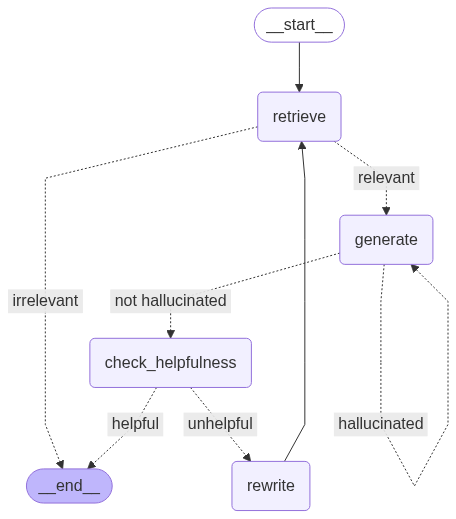

In [17]:
from IPython.display import Image, display
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는?'}
graph.invoke(initial_state)

관련성 : relevant
거짓말:  not hallucinated
유용성: helpful


{'query': '연봉 5천만원 거주자의 소득세는?',
 'context': [Document(metadata={'source': './tax.docx'}, page_content='제55조(세율) ①거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n\n| 종합소득 과세표준          | 세율                                         |\n\n|-------------------|--------------------------------------------|\n\n| 1,400만원 이하     | 과세표준의 6퍼센트                             |\n\n| 1,400만원 초과     5,000만원 이하     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)  |\n\n| 5,000만원 초과   8,800만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트) |\n\n| 8,800만원 초과 1억5천만원 이하    | 1,536만원 + (8,800만원을 초과하는 금액의 35퍼센트)|\n\n| 1억5천만원 초과 3억원 이하         | 3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)|\n\n| 3억원 초과    5억원 이하         | 9,406만원 + (3억원을 초과하는 금액의 38퍼센트)   |\n\n| 5억원 초과      10억원 이하        | 1억 7,406만원 + (5억원을 초과하는 금액의 42퍼센트)|\n\n| 10억원 초과        | 3억 8,406만원 + (10억원을 초과하는 금액의 45퍼센트)|\n\n\n\n\n\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순

In [19]:
initial_state = {'query': '점심 뭐먹을래?'}
graph.invoke(initial_state)

관련성 : irrelevant


{'query': '점심 뭐먹을래?',
 'context': [Document(metadata={'source': './tax.docx'}, page_content='다. 대통령령으로 정하는 농어가부업소득\n\n라. 대통령령으로 정하는 전통주의 제조에서 발생하는 소득\n\n마. 조림기간 5년 이상인 임지(林地)의 임목(林木)의 벌채 또는 양도로 발생하는 소득으로서 연 600만원 이하의 금액. 이 경우 조림기간 및 세액의 계산 등 필요한 사항은 대통령령으로 정한다.\n\n바. 대통령령으로 정하는 작물재배업에서 발생하는 소득\n\n사. 대통령령으로 정하는 어로어업 또는 양식어업에서 발생하는 소득\n\n3. 근로소득과 퇴직소득 중 다음 각 목의 어느 하나에 해당하는 소득\n\n가. 대통령령으로 정하는 복무 중인 병(兵)이 받는 급여\n\n나. 법률에 따라 동원된 사람이 그 동원 직장에서 받는 급여\n\n다. 「산업재해보상보험법」에 따라 수급권자가 받는 요양급여, 휴업급여, 장해급여, 간병급여, 유족급여, 유족특별급여, 장해특별급여, 장의비 또는 근로의 제공으로 인한 부상ㆍ질병ㆍ사망과 관련하여 근로자나 그 유족이 받는 배상ㆍ보상 또는 위자(慰藉)의 성질이 있는 급여\n\n라. 「근로기준법」 또는 「선원법」에 따라 근로자ㆍ선원 및 그 유족이 받는 요양보상금, 휴업보상금, 상병보상금(傷病補償金), 일시보상금, 장해보상금, 유족보상금, 행방불명보상금, 소지품 유실보상금, 장의비 및 장제비\n\n마. 「고용보험법」에 따라 받는 실업급여, 육아휴직 급여, 육아기 근로시간 단축 급여, 출산전후휴가 급여등, 「제대군인 지원에 관한 법률」에 따라 받는 전직지원금, 「국가공무원법」ㆍ「지방공무원법」에 따른 공무원 또는 「사립학교교직원 연금법」ㆍ「별정우체국법」을 적용받는 사람이 관련 법령에 따라 받는 육아휴직수당(「사립학교법」 제70조의2에 따라 임명된 사무직원이 학교의 정관 또는 규칙에 따라 지급받는 육아휴직수당으로서 대통령령으로 정하는 금액 이하의 것을 포함한다)\n\n바. 「국민연